# Улучшенный маппинг шахматной доски

Этот notebook содержит улучшенный алгоритм маппинга шахматной доски, который работает в различных условиях:
- Доски с закругленными углами
- Доски на не черных столах
- Доски с неровными границами
- Различные условия освещения

## Особенности:
- Адаптивное определение границ доски
- Проверка пустой доски при калибровке
- Сохранение данных маппинга по токену игры
- Улучшенная обработка перспективы


In [32]:
# Установка зависимостей
!pip install opencv-python opencv-contrib-python
!pip install numpy scipy
!pip install scikit-image
!pip install imutils


In [33]:
# Установка backend для matplotlib перед импортом (обход проблемы с _get)
import matplotlib
# Используем Agg backend для избежания проблем с интерактивным режимом
matplotlib.use('Agg')

import cv2
import numpy as np
import json
import os
from pathlib import Path
from typing import Tuple, List, Optional, Dict
from scipy import ndimage
from skimage import filters, morphology, measure
from datetime import datetime
import matplotlib.pyplot as plt

# Функция для безопасного создания фигур (обход проблемы с _get)
def create_figure(figsize=(12, 8), nrows=1, ncols=1):
    """Создает фигуру безопасным способом"""
    from matplotlib.figure import Figure
    from matplotlib.backends.backend_agg import FigureCanvasAgg
    from IPython.display import display, Image
    import io
    
    # Всегда используем прямой способ через Figure для избежания проблем
    fig = Figure(figsize=figsize)
    canvas = FigureCanvasAgg(fig)
    
    if nrows == 1 and ncols == 1:
        ax = fig.add_subplot(111)
        return fig, ax
    else:
        axes = []
        for i in range(nrows * ncols):
            ax = fig.add_subplot(nrows, ncols, i + 1)
            axes.append(ax)
        if nrows == 1 or ncols == 1:
            axes = axes[0] if len(axes) == 1 else axes
        return fig, axes

# Функция для отображения фигуры в Jupyter
def show_figure(fig):
    """Отображает фигуру в Jupyter notebook"""
    from IPython.display import display, Image
    import io
    
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=100, bbox_inches='tight')
    buf.seek(0)
    display(Image(buf.getvalue()))
    plt.close(fig)


## Настройка путей и параметров


In [34]:
# Настройки проекта
MAPPINGS_DIR = Path('../backend/chessboard_mappings')
MAPPINGS_DIR.mkdir(exist_ok=True)

# Параметры маппинга
OUTPUT_IMAGE_SIZE = (640, 640)  # Размер выходного изображения
MIN_BOARD_AREA_RATIO = 0.1  # Минимальная площадь доски относительно изображения
MAX_BOARD_AREA_RATIO = 0.9  # Максимальная площадь доски относительно изображения
SQUARE_COUNT = 8  # Количество клеток по одной стороне

# Параметры детекции доски
ADAPTIVE_THRESH_BLOCK_SIZE = 11
ADAPTIVE_THRESH_C = 2
CANNY_LOW_THRESHOLD = 50
CANNY_HIGH_THRESHOLD = 150
MIN_CONTOUR_AREA = 1000  # Минимальная площадь контура

print(f"Директория для маппингов: {MAPPINGS_DIR}")


Директория для маппингов: ..\backend\chessboard_mappings


## Вспомогательные функции


In [35]:
def order_points_clockwise(pts: np.ndarray) -> np.ndarray:
    """Упорядочивание точек по часовой стрелке (top-left, top-right, bottom-right, bottom-left)"""
    # Сортировка по x-координате
    x_sorted = pts[np.argsort(pts[:, 0]), :]
    
    # Левая и правая пары
    left_most = x_sorted[:2, :]
    right_most = x_sorted[2:, :]
    
    # Сортировка левой пары по y
    left_most = left_most[np.argsort(left_most[:, 1]), :]
    top_left, bottom_left = left_most
    
    # Сортировка правой пары по y
    right_most = right_most[np.argsort(right_most[:, 1]), :]
    top_right, bottom_right = right_most
    
    return np.array([top_left, top_right, bottom_right, bottom_left], dtype=np.float32)


def calculate_distance(p1: Tuple[float, float], p2: Tuple[float, float]) -> float:
    """Вычисление евклидова расстояния между двумя точками"""
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)


def perspective_transform(image: np.ndarray, corners: np.ndarray, output_size: Tuple[int, int]) -> np.ndarray:
    """Применение перспективного преобразования"""
    # Упорядочивание углов
    ordered_corners = order_points_clockwise(corners)
    
    # Вычисление размеров выходного изображения
    width_A = calculate_distance(ordered_corners[0], ordered_corners[1])
    width_B = calculate_distance(ordered_corners[2], ordered_corners[3])
    max_width = max(int(width_A), int(width_B))
    
    height_A = calculate_distance(ordered_corners[0], ordered_corners[3])
    height_B = calculate_distance(ordered_corners[1], ordered_corners[2])
    max_height = max(int(height_A), int(height_B))
    
    # Использование заданного размера или вычисленного
    if output_size:
        dst_width, dst_height = output_size
    else:
        dst_width, dst_height = max_width, max_height
    
    # Точки назначения
    dst_points = np.array([
        [0, 0],
        [dst_width - 1, 0],
        [dst_width - 1, dst_height - 1],
        [0, dst_height - 1]
    ], dtype=np.float32)
    
    # Матрица перспективного преобразования
    M = cv2.getPerspectiveTransform(ordered_corners, dst_points)
    
    # Применение преобразования
    warped = cv2.warpPerspective(image, M, (dst_width, dst_height))
    
    return warped, M


## Улучшенное определение границ доски


In [36]:
def detect_board_boundaries(image: np.ndarray, 
                           min_area_ratio: float = MIN_BOARD_AREA_RATIO,
                           max_area_ratio: float = MAX_BOARD_AREA_RATIO,
                           use_sam3: bool = False) -> Optional[np.ndarray]:
    """
    Улучшенное определение границ доски с использованием различных методов
    
    Параметры:
    - image: Входное изображение
    - min_area_ratio: Минимальная площадь доски относительно изображения
    - max_area_ratio: Максимальная площадь доски относительно изображения
    - use_sam3: Использовать ли SAM2.1 для определения границ (требует ultralytics>=8.3.0)
    
    Возвращает:
    - Массив из 4 точек углов доски или None
    """
    # Попытка использовать SAM2.1 если доступен и запрошен
    if use_sam3:
        try:
            from sam21_board_detection import detect_board_with_sam21_auto
            sam3_result = detect_board_with_sam21_auto(image)
            if sam3_result is not None:
                # Проверяем, что результат соответствует требованиям по размеру
                h, w = image.shape[:2]
                total_area = h * w
                min_area = total_area * min_area_ratio
                max_area = total_area * max_area_ratio
                
                # Вычисляем площадь найденной доски
                corners = sam3_result
                width = max(calculate_distance(corners[0], corners[1]), 
                           calculate_distance(corners[2], corners[3]))
                height = max(calculate_distance(corners[0], corners[3]), 
                            calculate_distance(corners[1], corners[2]))
                area = width * height
                
                if min_area <= area <= max_area:
                    return sam3_result
        except Exception as e:
            print(f"SAM2.1 detection failed, falling back to traditional method: {e}")
    
    # Традиционный метод
    h, w = image.shape[:2]
    total_area = h * w
    min_area = total_area * min_area_ratio
    max_area = total_area * max_area_ratio
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    
    # Метод 1: Адаптивный порог + морфология
    adaptive_thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, ADAPTIVE_THRESH_BLOCK_SIZE, ADAPTIVE_THRESH_C
    )
    
    # Инверсия для поиска темных границ
    thresh_inv = cv2.bitwise_not(adaptive_thresh)
    
    # Морфологические операции для соединения разрывов
    kernel = np.ones((3, 3), np.uint8)
    thresh_morph = cv2.morphologyEx(thresh_inv, cv2.MORPH_CLOSE, kernel, iterations=2)
    thresh_morph = cv2.morphologyEx(thresh_morph, cv2.MORPH_OPEN, kernel, iterations=1)
    
    # Поиск контуров
    contours, _ = cv2.findContours(thresh_morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Фильтрация контуров по площади
    valid_contours = [c for c in contours if min_area <= cv2.contourArea(c) <= max_area]
    
    if not valid_contours:
        # Метод 2: Canny edge detection + Hough lines
        return detect_board_by_lines(image, min_area, max_area)
    
    # Сортировка по площади (от большего к меньшему)
    valid_contours = sorted(valid_contours, key=cv2.contourArea, reverse=True)
    
    # Попытка найти четырехугольник
    for contour in valid_contours[:5]:  # Проверяем топ-5 контуров
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
        
        if len(approx) == 4:
            # Проверка, что это разумный четырехугольник
            area = cv2.contourArea(approx)
            if min_area <= area <= max_area:
                # Проверка соотношения сторон (доска должна быть примерно квадратной)
                corners = approx.reshape(4, 2)
                width = max(calculate_distance(corners[0], corners[1]), 
                           calculate_distance(corners[2], corners[3]))
                height = max(calculate_distance(corners[0], corners[3]), 
                            calculate_distance(corners[1], corners[2]))
                aspect_ratio = max(width, height) / min(width, height)
                
                if 0.7 <= aspect_ratio <= 1.3:  # Доска должна быть примерно квадратной
                    return corners.astype(np.float32)
    
    # Если не нашли четырехугольник, пробуем метод с линиями
    return detect_board_by_lines(image, min_area, max_area)


def detect_board_by_lines(image: np.ndarray, min_area: float, max_area: float) -> Optional[np.ndarray]:
    """Определение границ доски через поиск линий"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    
    # Размытие для уменьшения шума
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Canny edge detection
    edges = cv2.Canny(blurred, CANNY_LOW_THRESHOLD, CANNY_HIGH_THRESHOLD)
    
    # Морфология для соединения линий
    kernel = np.ones((3, 3), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=2)
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=3)
    
    # Hough Lines для поиска границ
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, 
                            minLineLength=min(image.shape[:2])//4, 
                            maxLineGap=50)
    
    if lines is None or len(lines) < 4:
        return None
    
    # Группировка линий по углам
    h_lines = []
    v_lines = []
    
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
        
        if abs(angle) < 45 or abs(angle) > 135:
            h_lines.append((x1, y1, x2, y2))
        else:
            v_lines.append((x1, y1, x2, y2))
    
    if len(h_lines) < 2 or len(v_lines) < 2:
        return None
    
    # Нахождение пересечений для определения углов
    # Упрощенный подход: находим крайние точки линий
    all_points = []
    for line in h_lines + v_lines:
        all_points.append((line[0], line[1]))
        all_points.append((line[2], line[3]))
    
    all_points = np.array(all_points)
    
    # Находим углы через выпуклую оболочку
    hull = cv2.convexHull(all_points)
    
    if len(hull) < 4:
        return None
    
    # Аппроксимация до четырехугольника
    peri = cv2.arcLength(hull, True)
    approx = cv2.approxPolyDP(hull, 0.02 * peri, True)
    
    if len(approx) == 4:
        area = cv2.contourArea(approx)
        if min_area <= area <= max_area:
            return approx.reshape(4, 2).astype(np.float32)
    
    return None


In [37]:
def detect_square_corners(warped_image: np.ndarray, square_count: int = SQUARE_COUNT) -> Optional[np.ndarray]:
    """
    Определение углов клеток доски на выровненном изображении
    
    Параметры:
    - warped_image: Выровненное изображение доски
    - square_count: Количество клеток по одной стороне (обычно 8)
    
    Возвращает:
    - Массив размером (square_count+1) x (square_count+1) x 2 с координатами углов
    """
    gray = cv2.cvtColor(warped_image, cv2.COLOR_BGR2GRAY) if len(warped_image.shape) == 3 else warped_image
    
    # Размытие
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)
    
    # Морфология для соединения линий
    kernel = np.ones((3, 3), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)
    
    # Hough Lines
    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=100)
    
    if lines is None:
        return None
    
    # Разделение на горизонтальные и вертикальные линии
    h_lines = []
    v_lines = []
    
    for rho, theta in lines[:, 0]:
        if theta < np.pi/4 or theta > 3*np.pi/4:
            v_lines.append((rho, theta))
        else:
            h_lines.append((rho, theta))
    
    if len(h_lines) < square_count or len(v_lines) < square_count:
        return None
    
    # Кластеризация линий для удаления дубликатов
    h_lines = cluster_lines(h_lines, square_count + 1)
    v_lines = cluster_lines(v_lines, square_count + 1)
    
    if len(h_lines) < square_count + 1 or len(v_lines) < square_count + 1:
        return None
    
    # Нахождение пересечений
    intersections = []
    for h_rho, h_theta in h_lines:
        for v_rho, v_theta in v_lines:
            # Решение системы уравнений для нахождения пересечения
            A = np.array([
                [np.cos(h_theta), np.sin(h_theta)],
                [np.cos(v_theta), np.sin(v_theta)]
            ])
            b = np.array([h_rho, v_rho])
            
            try:
                point = np.linalg.solve(A, b)
                if 0 <= point[0] < warped_image.shape[1] and 0 <= point[1] < warped_image.shape[0]:
                    intersections.append(point)
            except np.linalg.LinAlgError:
                continue
    
    if len(intersections) < (square_count + 1) ** 2:
        return None
    
    # Кластеризация точек пересечения
    intersections = np.array(intersections)
    clustered = cluster_intersection_points(intersections, square_count + 1)
    
    # Сортировка в матрицу
    matrix = sort_points_to_matrix(clustered, square_count + 1)
    
    return matrix


def cluster_lines(lines: List[Tuple[float, float]], target_count: int) -> List[Tuple[float, float]]:
    """Кластеризация линий для удаления дубликатов"""
    if len(lines) <= target_count:
        return lines
    
    # Сортировка по rho
    lines = sorted(lines, key=lambda x: x[0])
    
    # Простая кластеризация: группируем близкие линии
    clusters = []
    current_cluster = [lines[0]]
    
    for line in lines[1:]:
        if abs(line[0] - current_cluster[-1][0]) < 10:  # Порог близости
            current_cluster.append(line)
        else:
            # Сохраняем среднюю линию кластера
            avg_rho = np.mean([l[0] for l in current_cluster])
            avg_theta = np.mean([l[1] for l in current_cluster])
            clusters.append((avg_rho, avg_theta))
            current_cluster = [line]
    
    # Добавляем последний кластер
    if current_cluster:
        avg_rho = np.mean([l[0] for l in current_cluster])
        avg_theta = np.mean([l[1] for l in current_cluster])
        clusters.append((avg_rho, avg_theta))
    
    # Выбираем нужное количество линий
    if len(clusters) > target_count:
        # Выбираем равномерно распределенные
        indices = np.linspace(0, len(clusters) - 1, target_count, dtype=int)
        clusters = [clusters[i] for i in indices]
    
    return clusters


def cluster_intersection_points(points: np.ndarray, grid_size: int) -> np.ndarray:
    """Кластеризация точек пересечения"""
    from scipy.cluster.hierarchy import linkage, fcluster
    from scipy.spatial.distance import pdist
    
    if len(points) <= grid_size ** 2:
        return points
    
    # Иерархическая кластеризация
    distances = pdist(points)
    linkage_matrix = linkage(distances, method='ward')
    cluster_labels = fcluster(linkage_matrix, grid_size ** 2, criterion='maxclust')
    
    # Вычисление центроидов кластеров
    clustered_points = []
    for i in range(1, grid_size ** 2 + 1):
        cluster_points = points[cluster_labels == i]
        if len(cluster_points) > 0:
            centroid = np.mean(cluster_points, axis=0)
            clustered_points.append(centroid)
    
    return np.array(clustered_points)


def sort_points_to_matrix(points: np.ndarray, grid_size: int) -> np.ndarray:
    """Сортировка точек в матрицу grid_size x grid_size"""
    # Сортировка по y-координате
    y_sorted = points[np.argsort(points[:, 1])]
    
    matrix = []
    for i in range(grid_size):
        # Берем строку точек
        row_start = i * grid_size
        row_end = (i + 1) * grid_size
        row_points = y_sorted[row_start:row_end]
        
        # Сортировка по x внутри строки
        row_points = row_points[np.argsort(row_points[:, 0])]
        matrix.append(row_points)
    
    return np.array(matrix)


In [38]:
def is_board_empty(warped_image: np.ndarray, square_corners: np.ndarray, 
                   threshold: float = 0.15) -> Tuple[bool, float]:
    """
    Проверка, пуста ли доска
    
    Параметры:
    - warped_image: Выровненное изображение доски
    - square_corners: Матрица углов клеток
    - threshold: Порог вариации для определения пустоты (0-1)
    
    Возвращает:
    - (is_empty, confidence): Пуста ли доска и уверенность
    """
    gray = cv2.cvtColor(warped_image, cv2.COLOR_BGR2GRAY) if len(warped_image.shape) == 3 else warped_image
    
    # Вычисление статистики по клеткам
    square_variations = []
    
    for i in range(SQUARE_COUNT):
        for j in range(SQUARE_COUNT):
            # Координаты углов клетки
            pt1 = square_corners[i, j].astype(int)
            pt2 = square_corners[i, j + 1].astype(int)
            pt3 = square_corners[i + 1, j + 1].astype(int)
            pt4 = square_corners[i + 1, j].astype(int)
            
            # Создание маски для клетки
            mask = np.zeros(gray.shape, dtype=np.uint8)
            pts = np.array([pt1, pt2, pt3, pt4], dtype=np.int32)
            cv2.fillPoly(mask, [pts], 255)
            
            # Извлечение пикселей клетки
            square_pixels = gray[mask > 0]
            
            if len(square_pixels) > 0:
                # Вычисление стандартного отклонения (вариации)
                std = np.std(square_pixels)
                mean = np.mean(square_pixels)
                variation = std / (mean + 1e-5)  # Нормализованная вариация
                square_variations.append(variation)
    
    if not square_variations:
        return False, 0.0
    
    # Средняя вариация по всем клеткам
    avg_variation = np.mean(square_variations)
    
    # Если вариация низкая, доска скорее всего пуста
    is_empty = avg_variation < threshold
    confidence = 1.0 - min(avg_variation / threshold, 1.0)
    
    return is_empty, confidence


## Основная функция маппинга


In [39]:
def map_chessboard(image: np.ndarray, 
                  game_token: str,
                  check_empty: bool = True,
                  empty_threshold: float = 0.15,
                  output_size: Tuple[int, int] = OUTPUT_IMAGE_SIZE,
                  use_sam3: bool = False) -> Dict:
    """
    Полный процесс маппинга шахматной доски
    
    Параметры:
    - image: Входное изображение доски
    - game_token: Токен игры для сохранения данных
    - check_empty: Проверять ли пустоту доски
    - empty_threshold: Порог для проверки пустоты
    - output_size: Размер выходного изображения
    - use_sam3: Использовать ли SAM2.1 для определения границ (требует ultralytics>=8.3.0)
    
    Возвращает:
    - Словарь с данными маппинга
    """
    result = {
        'success': False,
        'game_token': game_token,
        'timestamp': datetime.now().isoformat(),
        'error': None,
        'is_empty': None,
        'empty_confidence': None,
        'board_corners': None,
        'square_corners': None,
        'perspective_matrix': None,
        'warped_image_shape': None
    }
    
    try:
        # Шаг 1: Определение границ доски
        board_corners = detect_board_boundaries(image, use_sam3=use_sam3)
        
        if board_corners is None:
            result['error'] = "Не удалось определить границы доски"
            return result
        
        result['board_corners'] = board_corners.tolist()
        
        # Шаг 2: Перспективное преобразование
        warped_image, perspective_matrix = perspective_transform(
            image, board_corners, output_size
        )
        
        result['perspective_matrix'] = perspective_matrix.tolist()
        result['warped_image_shape'] = warped_image.shape
        
        # Шаг 3: Определение углов клеток
        square_corners = detect_square_corners(warped_image, SQUARE_COUNT)
        
        if square_corners is None:
            result['error'] = "Не удалось определить углы клеток"
            return result
        
        result['square_corners'] = square_corners.tolist()
        
        # Шаг 4: Проверка пустоты доски (если требуется)
        if check_empty:
            is_empty, confidence = is_board_empty(warped_image, square_corners, empty_threshold)
            result['is_empty'] = is_empty
            result['empty_confidence'] = float(confidence)
            
            if not is_empty:
                result['error'] = f"Доска не пуста (уверенность: {confidence:.2f})"
                return result
        
        # Шаг 5: Успешное завершение
        result['success'] = True
        
        # Сохранение данных маппинга
        save_mapping_data(result, game_token)
        
        return result
        
    except Exception as e:
        result['error'] = str(e)
        return result


def save_mapping_data(mapping_data: Dict, game_token: str):
    """Сохранение данных маппинга по токену игры"""
    mapping_file = MAPPINGS_DIR / f'{game_token}_mapping.json'
    
    with open(mapping_file, 'w', encoding='utf-8') as f:
        json.dump(mapping_data, f, indent=2, ensure_ascii=False)
    
    print(f"Данные маппинга сохранены: {mapping_file}")


def load_mapping_data(game_token: str) -> Optional[Dict]:
    """Загрузка данных маппинга по токену игры"""
    mapping_file = MAPPINGS_DIR / f'{game_token}_mapping.json'
    
    if not mapping_file.exists():
        return None
    
    with open(mapping_file, 'r', encoding='utf-8') as f:
        return json.load(f)


## Применение маппинга к новым изображениям


In [40]:
def apply_mapping(image: np.ndarray, game_token: str) -> Optional[np.ndarray]:
    """
    Применение сохраненного маппинга к новому изображению
    
    Параметры:
    - image: Входное изображение
    - game_token: Токен игры для загрузки маппинга
    
    Возвращает:
    - Выровненное изображение доски или None
    """
    mapping_data = load_mapping_data(game_token)
    
    if mapping_data is None or not mapping_data.get('success'):
        print(f"Маппинг для токена {game_token} не найден или невалиден")
        return None
    
    board_corners = np.array(mapping_data['board_corners'], dtype=np.float32)
    output_size = tuple(mapping_data['warped_image_shape'][:2][::-1])  # (width, height)
    
    warped_image, _ = perspective_transform(image, board_corners, output_size)
    
    return warped_image


## Визуализация результатов


In [41]:
def visualize_mapping(image: np.ndarray, mapping_data: Dict, 
                    show_corners: bool = True, show_squares: bool = True):
    """Визуализация результатов маппинга"""
    fig, axes = create_figure(nrows=1, ncols=2, figsize=(16, 8))
    
    # Исходное изображение с границами доски
    img1 = image.copy()
    if mapping_data.get('board_corners'):
        corners = np.array(mapping_data['board_corners'], dtype=np.int32)
        cv2.polylines(img1, [corners], True, (0, 255, 0), 3)
        if show_corners:
            for i, corner in enumerate(corners):
                cv2.circle(img1, tuple(corner), 5, (255, 0, 0), -1)
                cv2.putText(img1, str(i), tuple(corner + 10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
    
    axes[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Исходное изображение с границами доски')
    axes[0].axis('off')
    
    # Выровненное изображение с сеткой клеток
    if mapping_data.get('square_corners'):
        # Применяем маппинг для получения выровненного изображения
        warped = apply_mapping(image, mapping_data['game_token'])
        
        if warped is not None:
            img2 = warped.copy()
            square_corners = np.array(mapping_data['square_corners'])
            
            if show_squares:
                # Рисуем сетку
                for i in range(SQUARE_COUNT + 1):
                    # Горизонтальные линии
                    pt1 = square_corners[i, 0].astype(int)
                    pt2 = square_corners[i, -1].astype(int)
                    cv2.line(img2, tuple(pt1), tuple(pt2), (0, 255, 0), 2)
                    
                    # Вертикальные линии
                    pt1 = square_corners[0, i].astype(int)
                    pt2 = square_corners[-1, i].astype(int)
                    cv2.line(img2, tuple(pt1), tuple(pt2), (0, 255, 0), 2)
            
            axes[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
            axes[1].set_title('Выровненная доска с сеткой клеток')
            axes[1].axis('off')
    
    fig.tight_layout()
    show_figure(fig)
    
    # Вывод информации
    print(f"Успех: {mapping_data.get('success', False)}")
    if mapping_data.get('is_empty') is not None:
        print(f"Доска пуста: {mapping_data['is_empty']} (уверенность: {mapping_data.get('empty_confidence', 0):.2f})")
    if mapping_data.get('error'):
        print(f"Ошибка: {mapping_data['error']}")


✅ Изображение загружено: (1280, 1280, 3)

🔍 Шаг 1: Определение границ доски...
✅ Границы доски определены: (4, 2)


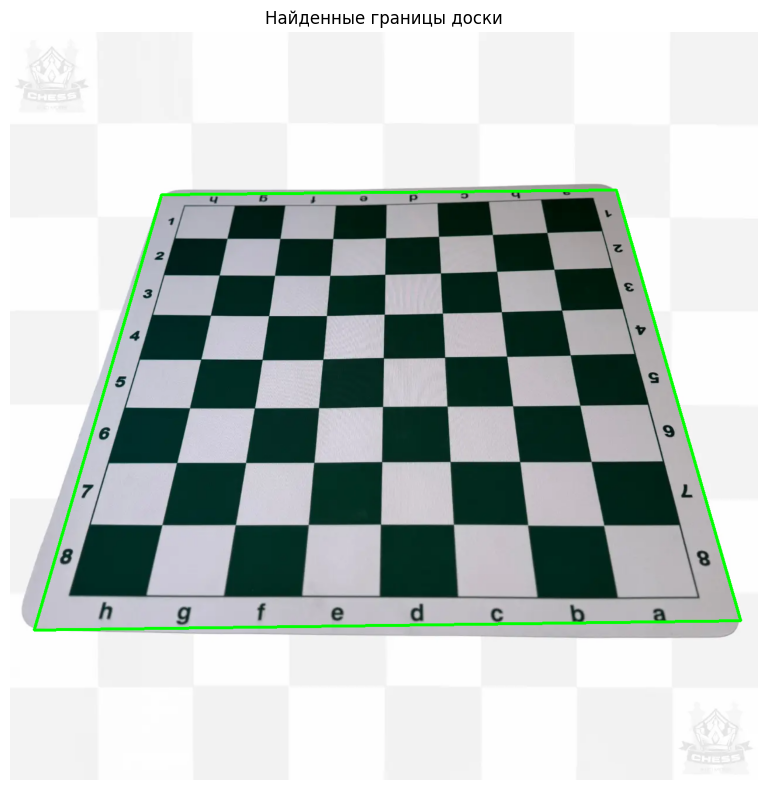


🔍 Шаг 2: Перспективное преобразование...
✅ Изображение выровнено: (640, 640, 3)


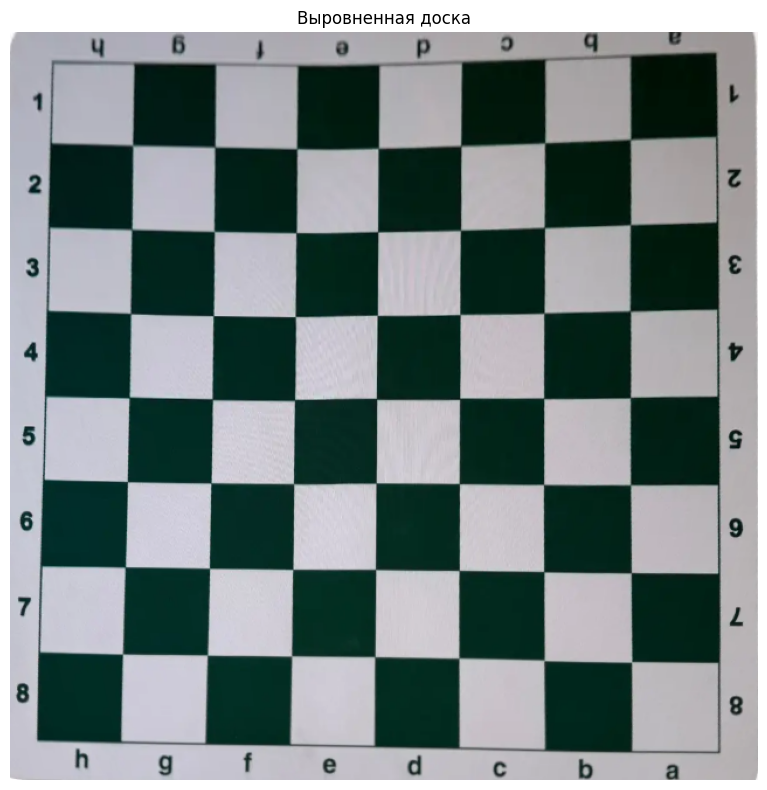


🔍 Шаг 3: Определение углов клеток...
❌ Не удалось определить углы клеток
💡 Попробуйте:
   - Убедиться, что доска пуста (без фигур)
   - Проверить качество изображения
   - Улучшить освещение
   Найдено линий: 80


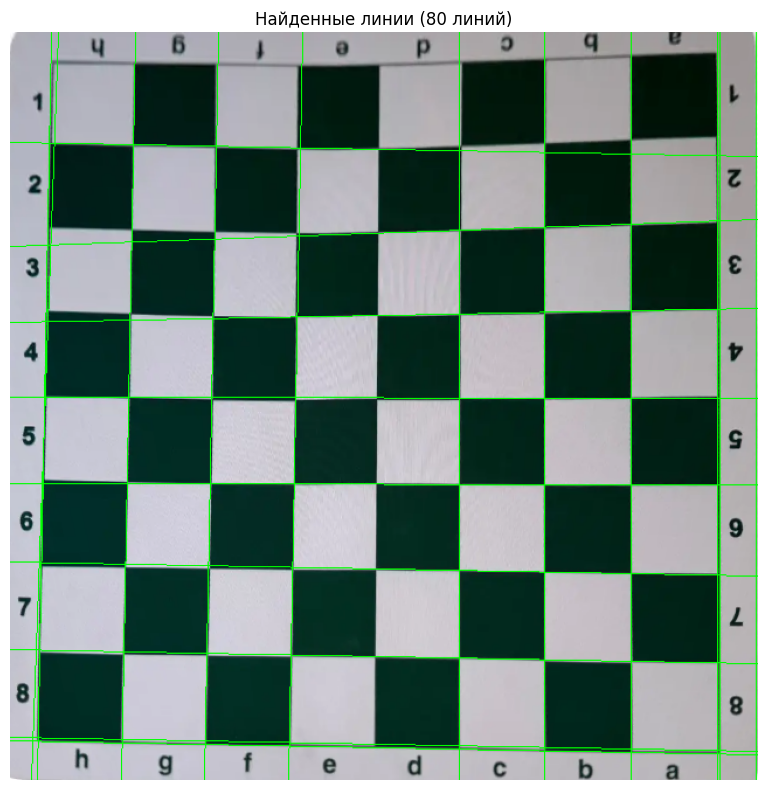


🔍 Выполнение полного маппинга...

❌ Ошибка маппинга: Не удалось определить углы клеток
   Детали: {'success': False, 'game_token': 'test1', 'timestamp': '2025-11-30T12:53:59.800035', 'error': 'Не удалось определить углы клеток', 'is_empty': None, 'empty_confidence': None, 'board_corners': [[1037.0, 270.0], [1250.0, 1007.0], [41.0, 1023.0], [259.0, 278.0]], 'square_corners': None, 'perspective_matrix': [[1.037573539614885, 0.3036121230014026, -353.13571695464515], [0.017382581723575548, 1.6904560726177096, -474.44887685412937], [4.672996230074699e-06, 0.0009430637488870574, 1.0]], 'warped_image_shape': (640, 640, 3)}


In [42]:
## Пример использования с отладкой

# Загрузка изображения
image_path = './image.png'
image = cv2.imread(image_path)

if image is None:
    print(f"❌ Ошибка: Не удалось загрузить изображение {image_path}")
else:
    print(f"✅ Изображение загружено: {image.shape}")
    
    # Токен игры (должен быть получен от фронтенда)
    game_token = 'test1'
    
    # ОТЛАДКА: Проверка границ доски
    print("\n🔍 Шаг 1: Определение границ доски...")
    board_corners = detect_board_boundaries(image)
    
    if board_corners is None:
        print("❌ Не удалось определить границы доски")
        print("💡 Попробуйте:")
        print("   - Улучшить освещение")
        print("   - Убедиться, что доска хорошо видна")
        print("   - Проверить, что доска на контрастном фоне")
    else:
        print(f"✅ Границы доски определены: {board_corners.shape}")
        
        # Визуализация границ
        img_with_corners = image.copy()
        cv2.polylines(img_with_corners, [board_corners.astype(np.int32)], True, (0, 255, 0), 3)
        fig, ax = create_figure(figsize=(12, 8))
        ax.imshow(cv2.cvtColor(img_with_corners, cv2.COLOR_BGR2RGB))
        ax.set_title('Найденные границы доски')
        ax.axis('off')
        fig.tight_layout()
        show_figure(fig)
        
        # ОТЛАДКА: Перспективное преобразование
        print("\n🔍 Шаг 2: Перспективное преобразование...")
        warped_image, perspective_matrix = perspective_transform(
            image, board_corners, OUTPUT_IMAGE_SIZE
        )
        print(f"✅ Изображение выровнено: {warped_image.shape}")
        
        # Визуализация выровненного изображения
        fig, ax = create_figure(figsize=(8, 8))
        ax.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
        ax.set_title('Выровненная доска')
        ax.axis('off')
        fig.tight_layout()
        show_figure(fig)
        
        # ОТЛАДКА: Определение углов клеток
        print("\n🔍 Шаг 3: Определение углов клеток...")
        square_corners = detect_square_corners(warped_image, SQUARE_COUNT)
        
        if square_corners is None:
            print("❌ Не удалось определить углы клеток")
            print("💡 Попробуйте:")
            print("   - Убедиться, что доска пуста (без фигур)")
            print("   - Проверить качество изображения")
            print("   - Улучшить освещение")
            
            # Показываем, что было найдено на выровненном изображении
            gray = cv2.cvtColor(warped_image, cv2.COLOR_BGR2GRAY)
            blurred = cv2.GaussianBlur(gray, (5, 5), 0)
            edges = cv2.Canny(blurred, 50, 150)
            
            # Пробуем найти линии
            lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=100)
            
            if lines is not None:
                print(f"   Найдено линий: {len(lines)}")
                # Визуализация линий
                img_lines = warped_image.copy()
                for rho, theta in lines[:20, 0]:  # Показываем первые 20 линий
                    a = np.cos(theta)
                    b = np.sin(theta)
                    x0 = a * rho
                    y0 = b * rho
                    x1 = int(x0 + 1000 * (-b))
                    y1 = int(y0 + 1000 * (a))
                    x2 = int(x0 - 1000 * (-b))
                    y2 = int(y0 - 1000 * (a))
                    cv2.line(img_lines, (x1, y1), (x2, y2), (0, 255, 0), 1)
                
                fig, ax = create_figure(figsize=(8, 8))
                ax.imshow(cv2.cvtColor(img_lines, cv2.COLOR_BGR2RGB))
                ax.set_title(f'Найденные линии ({len(lines)} линий)')
                ax.axis('off')
                fig.tight_layout()
                show_figure(fig)
            else:
                print("   Линии не найдены - возможно, доска не видна четко")
        else:
            print(f"✅ Углы клеток определены: {square_corners.shape}")
    
    # Выполнение полного маппинга
    print("\n🔍 Выполнение полного маппинга...")
    mapping_result = map_chessboard(
        image=image,
        game_token=game_token,
        check_empty=True,  # Проверять пустоту доски
        empty_threshold=0.15
    )
    
    # Проверка результата
    if mapping_result['success']:
        print("\n✅ Маппинг выполнен успешно!")
        if mapping_result['is_empty']:
            print(f"✅ Доска пуста (уверенность: {mapping_result.get('empty_confidence', 0):.2f}) - можно продолжать")
        else:
            print(f"⚠️ Доска не пуста (уверенность: {mapping_result.get('empty_confidence', 0):.2f}) - требуется очистка")
        
        # Визуализация
        visualize_mapping(image, mapping_result)
    else:
        print(f"\n❌ Ошибка маппинга: {mapping_result['error']}")
        print(f"   Детали: {mapping_result}")



## Использование SAM2.1 для калибровки доски

SAM2.1 (Segment Anything Model 2.1) от Ultralytics может использоваться для более точного определения границ доски, особенно в сложных условиях освещения или когда доска на неконтрастном фоне.

**Примечание:** SAM3 пока недоступен в ultralytics, используем SAM2.1 (самая новая доступная версия).


In [43]:
# Проверка доступности SAM2.1
try:
    import ultralytics
    print(f"✅ Ultralytics версия: {ultralytics.__version__}")
    
    # Пробуем разные способы импорта SAM
    try:
        # Способ 1: прямой импорт
        from ultralytics import SAM
        SAM_AVAILABLE = True
        print("✅ SAM2.1 доступен (прямой импорт)")
    except ImportError:
        try:
            # Способ 2: через models.sam
            from ultralytics.models.sam import SAM
            SAM_AVAILABLE = True
            print("✅ SAM2.1 доступен (через models.sam)")
        except ImportError:
            # Способ 3: через getattr
            SAM = getattr(ultralytics, 'SAM', None)
            if SAM is not None:
                SAM_AVAILABLE = True
                print("✅ SAM2.1 доступен (через getattr)")
            else:
                raise ImportError("SAM не найден в ultralytics")
    
    print("   Доступные модели: sam2.1_t (tiny), sam2.1_s (small), sam2.1_b (base), sam2.1_l (large)")
    print("   Модель будет скачана автоматически при первом использовании")
    
except ImportError as e:
    SAM_AVAILABLE = False
    print(f"⚠️ SAM2.1 не доступен: {e}")
    print("   Установите: pip install ultralytics>=8.3.0")
    print("   Или используйте: pip install -r requirements.txt")
    print("   После установки перезапустите kernel Jupyter")
except Exception as e:
    SAM_AVAILABLE = False
    print(f"⚠️ Ошибка при проверке SAM2.1: {e}")
    print("   Попробуйте перезапустить kernel Jupyter")


✅ Ultralytics версия: 8.3.233
✅ SAM2.1 доступен (прямой импорт)
   Доступные модели: sam2.1_t (tiny), sam2.1_s (small), sam2.1_b (base), sam2.1_l (large)
   Модель будет скачана автоматически при первом использовании


🔍 Попытка определения границ доски с SAM2.1...

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 1 30, 1 31, 1 32, 1 33, 1 34, 1 35, 1 36, 1 37, 1 38, 1 39, 1 40, 1 41, 1 42, 1 43, 1 44, 1 45, 1 46, 1 47, 1 48, 1 49, 1 50, 1 51, 1 52, 1 53, 1 54, 1 55, 1 56, 1 57, 1 58, 1 59, 1 60, 1 61, 1 62, 1 63, 1 64, 1 65, 1 66, 1 67, 1 68, 1 69, 1 70, 1 71, 1 72, 1 73, 1 74, 1 75, 1 76, 1 77, 1 78, 1 79, 1 80, 1 81, 1 82, 1 83, 1 84, 1 85, 1 86, 1 87, 1 88, 1 89, 1 90, 1 91, 1 92, 1 93, 1 94, 1 95, 1 96, 1 97, 1 98, 1 99, 1 100, 1 101, 1 102, 1 103, 1 104, 1 105, 1 106, 1 107, 1 108, 1 109, 1 110, 1 111, 1 112, 1 113, 1 114, 1 115, 1 116, 1 117, 1 118, 1 119, 1 120, 1 121, 1 122, 1 123, 11530.1ms
Speed: 13.3ms preprocess, 11530.1ms inference, 205.8ms postprocess per image at shape (1, 3, 1024, 1024)
✅ SAM2.1 нашел границы доски: (4, 2)


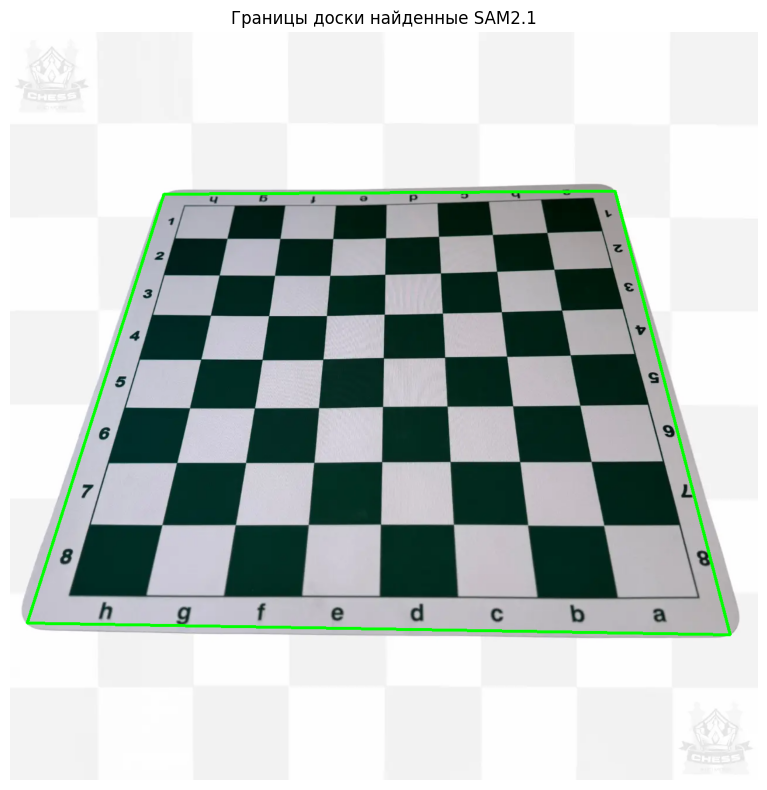


🔍 Сравнение с традиционным методом...
✅ Традиционный метод нашел границы: (4, 2)


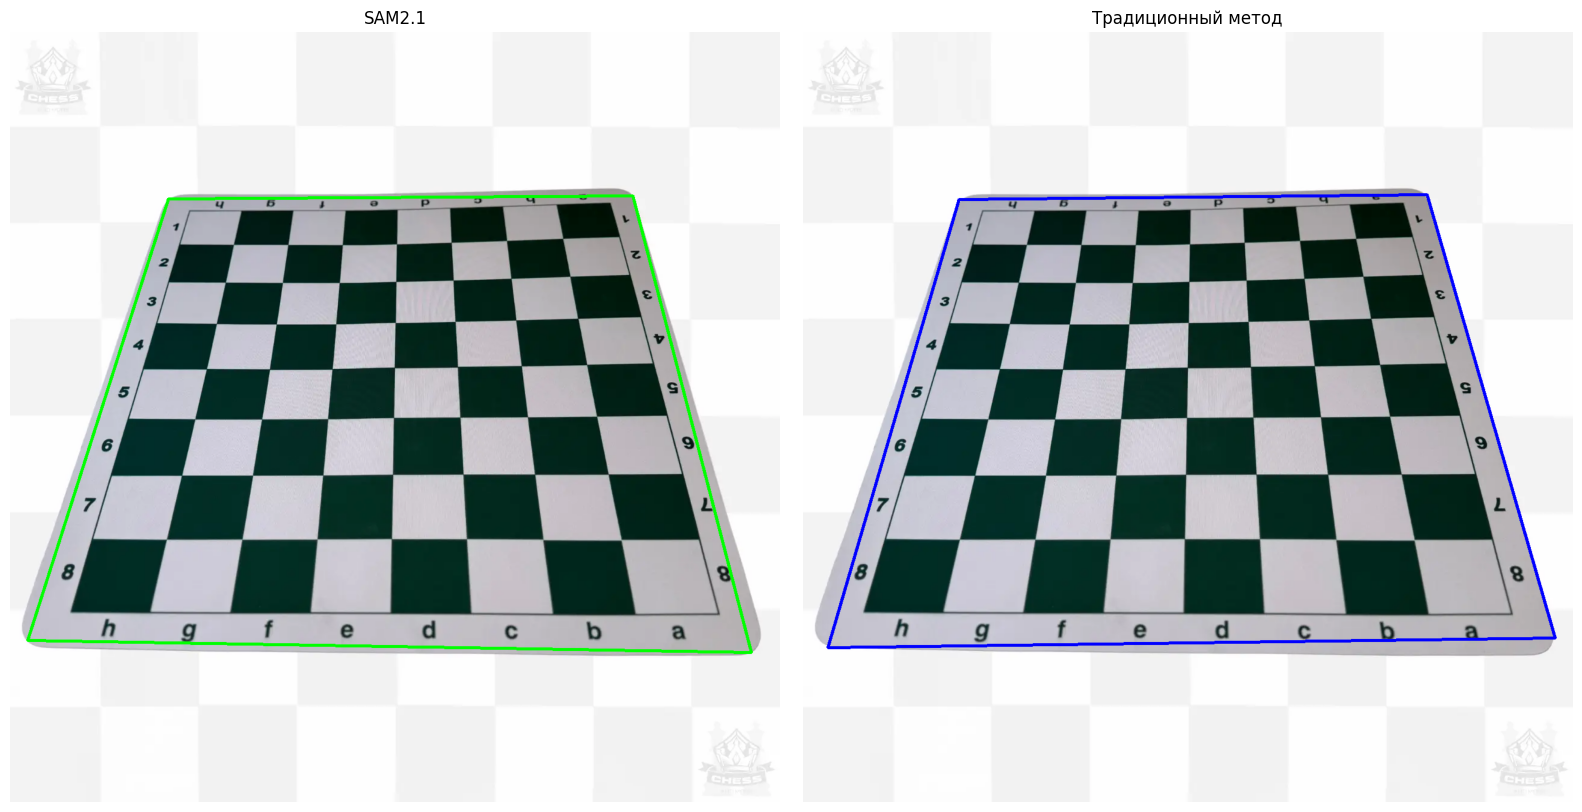

In [44]:
# Пример использования SAM2.1 для калибровки

if SAM_AVAILABLE:
    # Импортируем функции SAM3
    import sys
    sys.path.insert(0, './src')
    from sam21_board_detection import detect_board_with_sam21, detect_board_with_sam21_auto
    
    # Загрузка изображения
    image_path = './image.png'
    image = cv2.imread(image_path)
    
    if image is not None:
        print("🔍 Попытка определения границ доски с SAM2.1...")
        
        # Вариант 1: Автоматическое определение (без подсказок)
        board_corners_sam3 = detect_board_with_sam21_auto(image)
        
        if board_corners_sam3 is not None:
            print(f"✅ SAM2.1 нашел границы доски: {board_corners_sam3.shape}")
            
            # Визуализация
            img_with_corners = image.copy()
            cv2.polylines(img_with_corners, [board_corners_sam3.astype(np.int32)], True, (0, 255, 0), 3)
            fig, ax = create_figure(figsize=(12, 8))
            ax.imshow(cv2.cvtColor(img_with_corners, cv2.COLOR_BGR2RGB))
            ax.set_title('Границы доски найденные SAM2.1')
            ax.axis('off')
            fig.tight_layout()
            show_figure(fig)
            
            # Сравнение с традиционным методом
            print("\n🔍 Сравнение с традиционным методом...")
            board_corners_traditional = detect_board_boundaries(image, use_sam3=False)
            
            if board_corners_traditional is not None:
                print(f"✅ Традиционный метод нашел границы: {board_corners_traditional.shape}")
                
                # Визуализация сравнения
                fig, axes = create_figure(nrows=1, ncols=2, figsize=(16, 8))
                
                img1 = image.copy()
                cv2.polylines(img1, [board_corners_sam3.astype(np.int32)], True, (0, 255, 0), 3)
                axes[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
                axes[0].set_title('SAM2.1')
                axes[0].axis('off')
                
                img2 = image.copy()
                cv2.polylines(img2, [board_corners_traditional.astype(np.int32)], True, (255, 0, 0), 3)
                axes[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
                axes[1].set_title('Традиционный метод')
                axes[1].axis('off')
                
                fig.tight_layout()
                show_figure(fig)
            else:
                print("❌ Традиционный метод не нашел границы")
        else:
            print("❌ SAM2.1 не смог найти границы доски")
            print("💡 Попробуйте использовать подсказку (prompt_point или prompt_box)")
            
            # Вариант 2: С подсказкой (точка в центре доски)
            h, w = image.shape[:2]
            center_point = (w // 2, h // 2)
            print(f"\n🔍 Попытка с подсказкой (центр изображения: {center_point})...")
            
            board_corners_sam3_prompt = detect_board_with_sam21(image, prompt_point=center_point)
            if board_corners_sam3_prompt is not None:
                print(f"✅ SAM2.1 с подсказкой нашел границы: {board_corners_sam3_prompt.shape}")
                
                img_with_corners = image.copy()
                cv2.polylines(img_with_corners, [board_corners_sam3_prompt.astype(np.int32)], True, (0, 255, 0), 3)
                cv2.circle(img_with_corners, center_point, 10, (255, 0, 0), -1)  # Показываем точку-подсказку
                fig, ax = create_figure(figsize=(12, 8))
                ax.imshow(cv2.cvtColor(img_with_corners, cv2.COLOR_BGR2RGB))
                ax.set_title('SAM2.1 с подсказкой (красная точка)')
                ax.axis('off')
                fig.tight_layout()
                show_figure(fig)
    else:
        print("❌ Не удалось загрузить изображение")
else:
    print("⚠️ SAM2.1 не доступен. Используйте традиционный метод.")
    print("   Установите зависимости: pip install -r requirements.txt")


In [45]:
# Использование SAM2.1 в полном процессе маппинга

if SAM_AVAILABLE:
    image_path = './image.png'
    image = cv2.imread(image_path)
    game_token = 'test_sam3'
    
    if image is not None:
        print("🔍 Выполнение маппинга с использованием SAM2.1...")
        
        # Используем SAM2.1 для определения границ
        mapping_result = map_chessboard(
            image=image,
            game_token=game_token,
            check_empty=True,
            empty_threshold=0.15,
            use_sam3=True  # Включаем SAM2.1 (параметр назван sam3 для обратной совместимости)
        )
        
        if mapping_result['success']:
            print("✅ Маппинг с SAM2.1 выполнен успешно!")
            visualize_mapping(image, mapping_result)
        else:
            print(f"❌ Ошибка маппинга с SAM2.1: {mapping_result['error']}")
            print("\n💡 Попробуем без SAM3...")
            
            # Fallback на традиционный метод
            mapping_result = map_chessboard(
                image=image,
                game_token=game_token + '_traditional',
                check_empty=True,
                empty_threshold=0.15,
                use_sam3=False
            )
            
            if mapping_result['success']:
                print("✅ Маппинг традиционным методом выполнен успешно!")
                visualize_mapping(image, mapping_result)
            else:
                print(f"❌ Ошибка и традиционным методом: {mapping_result['error']}")
else:
    print("⚠️ SAM2.1 не доступен. Используйте обычный метод маппинга.")


🔍 Выполнение маппинга с использованием SAM2.1...

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 1 30, 1 31, 1 32, 1 33, 1 34, 1 35, 1 36, 1 37, 1 38, 1 39, 1 40, 1 41, 1 42, 1 43, 1 44, 1 45, 1 46, 1 47, 1 48, 1 49, 1 50, 1 51, 1 52, 1 53, 1 54, 1 55, 1 56, 1 57, 1 58, 1 59, 1 60, 1 61, 1 62, 1 63, 1 64, 1 65, 1 66, 1 67, 1 68, 1 69, 1 70, 1 71, 1 72, 1 73, 1 74, 1 75, 1 76, 1 77, 1 78, 1 79, 1 80, 1 81, 1 82, 1 83, 1 84, 1 85, 1 86, 1 87, 1 88, 1 89, 1 90, 1 91, 1 92, 1 93, 1 94, 1 95, 1 96, 1 97, 1 98, 1 99, 1 100, 1 101, 1 102, 1 103, 1 104, 1 105, 1 106, 1 107, 1 108, 1 109, 1 110, 1 111, 1 112, 1 113, 1 114, 1 115, 1 116, 1 117, 1 118, 1 119, 1 120, 1 121, 1 122, 1 123, 11844.7ms
Speed: 11.9ms preprocess, 11844.7ms inference, 231.8ms postprocess per image at shape (1, 3, 1024, 1024)
❌ Ошибка маппинга с SAM2.1: Не удалось определить углы клеток

💡